In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.metrics import auc
sys.path.append('./..')
sys.path.append('./../..')
sys.path.append('./../../..')
try:
    from . import utils
except:
    import utils
import argparse

import torch
from torch import FloatTensor as FT
from torch import LongTensor as LT
from torch import nn
from torch.nn import functional as F
import yaml
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import argparse

In [4]:
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher

try:
    from .model import StackedAE
except:
    from model import StackedAE

EPSILON = math.pow(10, -6)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device  >> ', DEVICE)
print('=========================== ')

def train_model(
    DATA_SET,
    data_dict,
    config
):
    layer_dims = config[DATA_SET]['layer_dims']
    train_df = data_dict['train']
    train_X = train_df.values
    data_dim = train_X.shape[1]

    epochs_1 = config[DATA_SET]['epochs_1']
    epochs_2 = config[DATA_SET]['epochs_2']

    dae_obj = StackedAE(
        DEVICE,
        data_dim,
        layer_dims,  # Provide the half (encoder only)
        op_activation='sigmoid',
        layer_activation='tanh',
        dropout=0.2,
        LR=0.05,
        num_epochs_1=epochs_1,
        num_epochs_2=epochs_2,
        min_epochs=5,
        batch_size=512,
        stop_threshold=0.05,
        checkpoint_dir=DATA_SET,
    )
    dae_obj.train_model(train_X)

    return dae_obj

def test_eval(
    dae_obj,
    data_dict,
    num_anomaly_sets
):
    test_X = data_dict['test'].values
    test_labels = [0 for _ in range(test_X.shape[0])]
    test_scores = dae_obj.score_samples(test_X)
    auc_list = []

    for idx in range(num_anomaly_sets):
        key = 'anom_' + str(idx+1)
        anom_X = data_dict[key].values
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_scores = dae_obj.score_samples(anom_X)

        combined_scores = np.concatenate([anom_scores, test_scores], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)

        res_data = []
        for i, j in zip(combined_scores, combined_labels):
            res_data.append((i, j))
        res_df = pd.DataFrame(res_data, columns=['score', 'label'])

        #  Normalize values
        def _normalize_(val, _min, _max):
            return (val - _min) / (_max - _min)

        _max = max(combined_scores)
        _min = min(combined_scores)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min, _max,)
        )

        res_df = res_df.sort_values(by=['score'], ascending=False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        step = (_max - _min) / 100

        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = [0]

        while thresh >= _min:
            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0:
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1]
            prec = len(correct) / len(sel)
            rec = len(correct) / num_anomalies
            P.append(prec)
            R.append(rec)
            if rec >= 1.0 :
                break
            thresh -= step
            thresh = round(thresh,3)
        P = [P[0]] + P


        pr_auc = auc(R, P)
        auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass

    _mean = np.mean(auc_list)
    _std = np.std(auc_list)
    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std', np.std(auc_list))
    return _mean, _std

# ==============================================================

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda
Current device  >>  cuda


In [5]:
# parser = argparse.ArgumentParser(description='Run the model ')
# parser.add_argument(
#     '--DATA_SET',
#     type=str,
#     help=' Which data set ?',
#     default=None,
#     choices=['kddcup', 'kddcup_neptune', 'nsl_kdd', 'nb15']
# )

# parser.add_argument(
#     '--num_runs',
#     type=str,
#     default=4,
#     help='Number of runs'
# )

In [6]:
# args = parser.parse_args()
# DATA_SET = args.DATA_SET
# num_runs = args.num_runs
# LOG_FILE = 'log_results_{}.txt'.format(DATA_SET)
# LOGGER = utils.get_logger(LOG_FILE)
# utils.log_time(LOGGER)
# LOGGER.info(DATA_SET)

In [20]:
DATA_SET = 'nb15'
num_runs = 5

In [21]:
config_file = 'config.yaml'
with open(config_file, 'r') as fh:
    config = yaml.safe_load(fh)

num_anomaly_sets = config[DATA_SET]['num_anomaly_sets']
anomaly_ratio = config[DATA_SET]['anomaly_ratio']
results = []

config_file = 'config.yaml'
with open(config_file, 'r') as fh:
    config = yaml.safe_load(fh)

num_anomaly_sets = config[DATA_SET]['num_anomaly_sets']
anomaly_ratio = config[DATA_SET]['anomaly_ratio']
results = []

  0%|          | 0/10 [00:00<?, ?it/s]

Greedy layerwise pretarining started
 Num AE layers  3
Adding layer : 1
Adding layer index  0
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 47.229485


 10%|█         | 1/10 [00:00<00:02,  3.03it/s]

 Epoch 1 loss 2.441093
Loss 1.006578


 20%|██        | 2/10 [00:00<00:02,  3.06it/s]

 Epoch 2 loss 0.855606
Loss 0.709884


 30%|███       | 3/10 [00:00<00:02,  3.22it/s]

 Epoch 3 loss 0.664988
Loss 0.660021


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 Epoch 4 loss 0.620560
Loss 0.521381


 50%|█████     | 5/10 [00:01<00:01,  3.07it/s]

 Epoch 5 loss 0.611296
Loss 0.667405


 60%|██████    | 6/10 [00:01<00:01,  3.13it/s]

 Epoch 6 loss 0.603823
Loss 0.576085


 70%|███████   | 7/10 [00:02<00:00,  3.24it/s]

 Epoch 7 loss 0.503857
Loss 0.442192


 80%|████████  | 8/10 [00:02<00:00,  3.17it/s]

 Epoch 8 loss 0.410695
Loss 0.315485


 90%|█████████ | 9/10 [00:02<00:00,  3.22it/s]

 Epoch 9 loss 0.365000
Loss 0.389110


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 0.345330
Adding layer : 2
Adding layer index  1
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 24.423023


 10%|█         | 1/10 [00:00<00:03,  2.97it/s]

 Epoch 1 loss 3.989736
Loss 3.680432


 20%|██        | 2/10 [00:00<00:02,  2.96it/s]

 Epoch 2 loss 3.627268
Loss 3.460426


 30%|███       | 3/10 [00:01<00:02,  2.97it/s]

 Epoch 3 loss 3.595427
Loss 3.786083


 40%|████      | 4/10 [00:01<00:02,  2.96it/s]

 Epoch 4 loss 3.576359
Loss 3.443396


 50%|█████     | 5/10 [00:01<00:01,  2.95it/s]

 Epoch 5 loss 3.558015
Loss 3.552413


 60%|██████    | 6/10 [00:02<00:01,  2.71it/s]

 Epoch 6 loss 3.529544
Loss 3.454253


 70%|███████   | 7/10 [00:02<00:01,  2.74it/s]

 Epoch 7 loss 3.544992
Loss 3.660517


 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

 Epoch 8 loss 3.536664
Loss 3.541093


 90%|█████████ | 9/10 [00:03<00:00,  2.84it/s]

 Epoch 9 loss 3.518977
Loss 3.307359


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.526634
Adding layer : 3
Adding layer index  2
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmo

 10%|█         | 1/10 [00:00<00:03,  2.46it/s]

 Epoch 1 loss 4.089595
Loss 3.757321


 20%|██        | 2/10 [00:00<00:03,  2.50it/s]

 Epoch 2 loss 3.800624
Loss 3.644569


 30%|███       | 3/10 [00:01<00:02,  2.52it/s]

 Epoch 3 loss 3.714458
Loss 3.596383


 40%|████      | 4/10 [00:01<00:02,  2.54it/s]

 Epoch 4 loss 3.559801
Loss 3.430200


 50%|█████     | 5/10 [00:01<00:01,  2.57it/s]

 Epoch 5 loss 3.541171
Loss 3.478988


 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

 Epoch 6 loss 3.531481
Loss 3.551134


 70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

 Epoch 7 loss 3.520264
Loss 3.665684


 80%|████████  | 8/10 [00:03<00:00,  2.38it/s]

 Epoch 8 loss 3.507171
Loss 3.588033


 90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

 Epoch 9 loss 3.505831
Loss 3.466544


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.499744
Greedy layer-wise pretraining [Done]
Loss 3.423888


 10%|█         | 1/10 [00:00<00:05,  1.80it/s]

 Epoch 1 loss 3.487965
Loss 3.101058


 20%|██        | 2/10 [00:01<00:04,  1.84it/s]

 Epoch 2 loss 3.032532
Loss 3.067676


 30%|███       | 3/10 [00:01<00:03,  1.88it/s]

 Epoch 3 loss 2.951691
Loss 2.910419


 40%|████      | 4/10 [00:02<00:03,  1.91it/s]

 Epoch 4 loss 2.940437
Loss 3.010513


 50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

 Epoch 5 loss 2.921999
Loss 2.908856


 60%|██████    | 6/10 [00:03<00:02,  1.94it/s]

 Epoch 6 loss 2.921917
Loss 2.735096


 70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

 Epoch 7 loss 2.923015
Loss 2.959960


 80%|████████  | 8/10 [00:04<00:01,  1.94it/s]

 Epoch 8 loss 2.922106
Loss 2.972627


 90%|█████████ | 9/10 [00:04<00:00,  1.95it/s]

 Epoch 9 loss 2.928972
Loss 2.974982


  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 10 loss 2.915317
Epoch :: 1
Loss 2.830130


  4%|▍         | 1/25 [00:00<00:12,  1.90it/s]

Epoch :: 2
Loss 2.935073


  8%|▊         | 2/25 [00:01<00:11,  1.94it/s]

Epoch :: 3
Loss 2.921073


 12%|█▏        | 3/25 [00:01<00:11,  1.98it/s]

Epoch :: 4
Loss 2.844413


 16%|█▌        | 4/25 [00:01<00:10,  2.01it/s]

Epoch :: 5
Loss 2.838748


 20%|██        | 5/25 [00:02<00:09,  2.03it/s]

Epoch :: 6
Loss 2.927555


 24%|██▍       | 6/25 [00:02<00:09,  2.04it/s]

Epoch :: 7
Loss 2.965106


 28%|██▊       | 7/25 [00:03<00:08,  2.05it/s]

Epoch :: 8
Loss 2.814630


 32%|███▏      | 8/25 [00:03<00:08,  1.99it/s]

Epoch :: 9
Loss 2.823973


 36%|███▌      | 9/25 [00:04<00:09,  1.76it/s]

Epoch :: 10
Loss 2.858433


 40%|████      | 10/25 [00:05<00:08,  1.71it/s]

Epoch :: 11
Loss 2.816811


 44%|████▍     | 11/25 [00:05<00:07,  1.80it/s]

Epoch :: 12
Loss 2.727860


 48%|████▊     | 12/25 [00:06<00:06,  1.87it/s]

Epoch :: 13
Loss 2.830832


 52%|█████▏    | 13/25 [00:06<00:06,  1.88it/s]

Epoch :: 14
Loss 2.885755


 56%|█████▌    | 14/25 [00:07<00:05,  1.88it/s]

Epoch :: 15
Loss 2.670000


 60%|██████    | 15/25 [00:07<00:05,  1.93it/s]

Epoch :: 16
Loss 2.869932


 64%|██████▍   | 16/25 [00:08<00:04,  1.92it/s]

Epoch :: 17
Loss 2.862796


 68%|██████▊   | 17/25 [00:08<00:04,  1.90it/s]

Epoch :: 18
Loss 2.811924


 72%|███████▏  | 18/25 [00:09<00:03,  1.89it/s]

Epoch :: 19
Loss 2.760884


 76%|███████▌  | 19/25 [00:10<00:03,  1.84it/s]

Epoch :: 20
Loss 2.796185


 80%|████████  | 20/25 [00:10<00:02,  1.79it/s]

Epoch :: 21
Loss 2.760634


 84%|████████▍ | 21/25 [00:11<00:02,  1.81it/s]

Epoch :: 22
Loss 2.916315


 88%|████████▊ | 22/25 [00:11<00:01,  1.85it/s]

Epoch :: 23
Loss 2.836848


 92%|█████████▏| 23/25 [00:12<00:01,  1.87it/s]

Epoch :: 24
Loss 2.821104


 96%|█████████▌| 24/25 [00:12<00:00,  1.91it/s]

Epoch :: 25
Loss 2.969016


100%|██████████| 4/4 [00:00<00:00, 709.82it/s]


AUC : 0.2559 


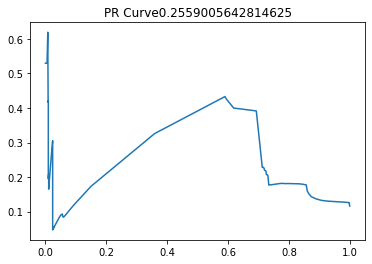

100%|██████████| 4/4 [00:00<00:00, 422.82it/s]


AUC : 0.2507 


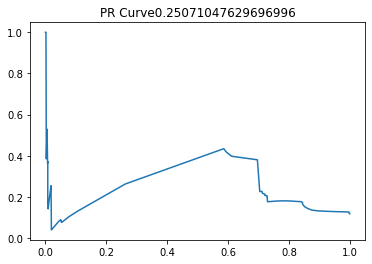

100%|██████████| 4/4 [00:00<00:00, 498.62it/s]


AUC : 0.2465 


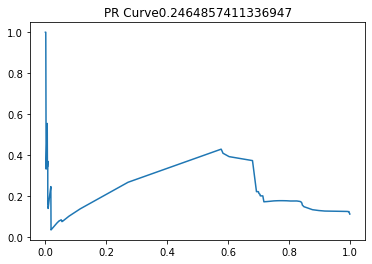

100%|██████████| 4/4 [00:00<00:00, 812.02it/s]


AUC : 0.2469 


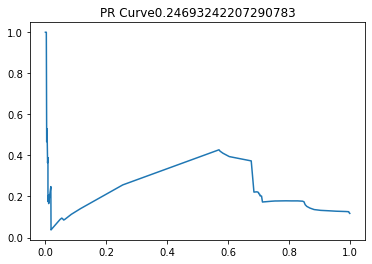

100%|██████████| 4/4 [00:00<00:00, 642.58it/s]


AUC : 0.2513 


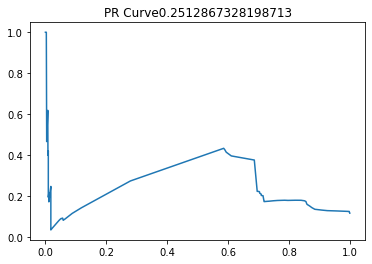

 Mean AUC  0.2502631873209813
 AUC std 0.0034173331311572


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy layerwise pretarining started
 Num AE layers  3
Adding layer : 1
Adding layer index  0
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 47.621552


 10%|█         | 1/10 [00:00<00:02,  3.23it/s]

 Epoch 1 loss 2.591010
Loss 0.936806


 20%|██        | 2/10 [00:00<00:02,  3.31it/s]

 Epoch 2 loss 0.799137
Loss 0.683672


 30%|███       | 3/10 [00:00<00:02,  3.19it/s]

 Epoch 3 loss 0.665512
Loss 0.541283


 40%|████      | 4/10 [00:01<00:01,  3.19it/s]

 Epoch 4 loss 0.597925
Loss 0.619605


 50%|█████     | 5/10 [00:01<00:01,  3.03it/s]

 Epoch 5 loss 0.568743
Loss 0.602200


 60%|██████    | 6/10 [00:01<00:01,  3.07it/s]

 Epoch 6 loss 0.532843
Loss 0.439016


 70%|███████   | 7/10 [00:02<00:00,  3.04it/s]

 Epoch 7 loss 0.499320
Loss 0.460313


 80%|████████  | 8/10 [00:02<00:00,  3.02it/s]

 Epoch 8 loss 0.477420
Loss 0.435547


 90%|█████████ | 9/10 [00:02<00:00,  2.98it/s]

 Epoch 9 loss 0.428136
Loss 0.404716


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 0.370807
Adding layer : 2
Adding layer index  1
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 55.271042


 10%|█         | 1/10 [00:00<00:03,  2.83it/s]

 Epoch 1 loss 5.891202
Loss 4.320015


 20%|██        | 2/10 [00:00<00:02,  2.86it/s]

 Epoch 2 loss 3.935303
Loss 3.681561


 30%|███       | 3/10 [00:01<00:02,  2.90it/s]

 Epoch 3 loss 3.557079
Loss 3.423364


 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

 Epoch 4 loss 3.466827
Loss 3.291800


 50%|█████     | 5/10 [00:01<00:01,  2.93it/s]

 Epoch 5 loss 3.213289
Loss 3.149282


 60%|██████    | 6/10 [00:02<00:01,  2.84it/s]

 Epoch 6 loss 3.139897
Loss 3.237129


 70%|███████   | 7/10 [00:02<00:01,  2.86it/s]

 Epoch 7 loss 3.109353
Loss 3.048804


 80%|████████  | 8/10 [00:02<00:00,  2.89it/s]

 Epoch 8 loss 3.074725
Loss 2.924208


 90%|█████████ | 9/10 [00:03<00:00,  2.92it/s]

 Epoch 9 loss 2.875167
Loss 2.980445


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 2.769952
Adding layer : 3
Adding layer index  2
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmo

 10%|█         | 1/10 [00:00<00:03,  2.57it/s]

 Epoch 1 loss 4.023235
Loss 3.862833


 20%|██        | 2/10 [00:00<00:03,  2.58it/s]

 Epoch 2 loss 3.862376
Loss 3.722031


 30%|███       | 3/10 [00:01<00:02,  2.59it/s]

 Epoch 3 loss 3.815192
Loss 3.739424


 40%|████      | 4/10 [00:01<00:02,  2.61it/s]

 Epoch 4 loss 3.826695
Loss 3.914699


 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

 Epoch 5 loss 3.832055
Loss 3.998166


 60%|██████    | 6/10 [00:02<00:01,  2.45it/s]

 Epoch 6 loss 3.822021
Loss 3.725549


 70%|███████   | 7/10 [00:02<00:01,  2.38it/s]

 Epoch 7 loss 3.823538
Loss 3.798401


 80%|████████  | 8/10 [00:03<00:00,  2.35it/s]

 Epoch 8 loss 3.820929
Loss 3.603625


 90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

 Epoch 9 loss 3.824273
Loss 3.801200


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.820891
Greedy layer-wise pretraining [Done]
Loss 3.693108


 10%|█         | 1/10 [00:00<00:05,  1.75it/s]

 Epoch 1 loss 3.511761
Loss 3.270191


 20%|██        | 2/10 [00:01<00:04,  1.81it/s]

 Epoch 2 loss 3.178427
Loss 3.237040


 30%|███       | 3/10 [00:01<00:04,  1.74it/s]

 Epoch 3 loss 3.122526
Loss 3.058529


 40%|████      | 4/10 [00:02<00:03,  1.81it/s]

 Epoch 4 loss 3.080924
Loss 2.965043


 50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

 Epoch 5 loss 3.079269
Loss 3.023393


 60%|██████    | 6/10 [00:03<00:02,  1.73it/s]

 Epoch 6 loss 3.065575
Loss 3.142207


 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

 Epoch 7 loss 3.059068
Loss 3.091176


 80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

 Epoch 8 loss 3.074912
Loss 2.995392


 90%|█████████ | 9/10 [00:04<00:00,  1.88it/s]

 Epoch 9 loss 3.061032
Loss 3.040110


  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 10 loss 3.022814
Epoch :: 1
Loss 3.026805


  4%|▍         | 1/25 [00:00<00:12,  1.90it/s]

Epoch :: 2
Loss 1.713885


  8%|▊         | 2/25 [00:01<00:11,  1.95it/s]

Epoch :: 3
Loss 1.607591


 12%|█▏        | 3/25 [00:01<00:11,  1.98it/s]

Epoch :: 4
Loss 1.536757


 16%|█▌        | 4/25 [00:01<00:10,  2.01it/s]

Epoch :: 5
Loss 1.624291


 20%|██        | 5/25 [00:02<00:09,  2.03it/s]

Epoch :: 6
Loss 1.480816


 24%|██▍       | 6/25 [00:02<00:09,  2.03it/s]

Epoch :: 7
Loss 1.395055


 28%|██▊       | 7/25 [00:03<00:08,  2.04it/s]

Epoch :: 8
Loss 1.359130


 32%|███▏      | 8/25 [00:03<00:08,  2.04it/s]

Epoch :: 9
Loss 1.221167


 36%|███▌      | 9/25 [00:04<00:07,  2.05it/s]

Epoch :: 10
Loss 1.181752


 40%|████      | 10/25 [00:04<00:07,  2.05it/s]

Epoch :: 11
Loss 1.204611


 44%|████▍     | 11/25 [00:05<00:06,  2.05it/s]

Epoch :: 12
Loss 1.259513


 48%|████▊     | 12/25 [00:05<00:06,  2.06it/s]

Epoch :: 13
Loss 1.196889


 52%|█████▏    | 13/25 [00:06<00:05,  2.06it/s]

Epoch :: 14
Loss 1.172738


 56%|█████▌    | 14/25 [00:06<00:05,  2.07it/s]

Epoch :: 15
Loss 1.153977


 60%|██████    | 15/25 [00:07<00:04,  2.06it/s]

Epoch :: 16
Loss 1.168567


 64%|██████▍   | 16/25 [00:07<00:04,  2.06it/s]

Epoch :: 17
Loss 1.145962


 68%|██████▊   | 17/25 [00:08<00:03,  2.06it/s]

Epoch :: 18
Loss 1.161078


 72%|███████▏  | 18/25 [00:08<00:03,  1.87it/s]

Epoch :: 19
Loss 1.118822


 76%|███████▌  | 19/25 [00:09<00:03,  1.92it/s]

Epoch :: 20
Loss 0.974487


 80%|████████  | 20/25 [00:09<00:02,  1.92it/s]

Epoch :: 21
Loss 1.076690


 84%|████████▍ | 21/25 [00:10<00:02,  1.96it/s]

Epoch :: 22
Loss 1.102216


 88%|████████▊ | 22/25 [00:10<00:01,  2.00it/s]

Epoch :: 23
Loss 0.987306


 92%|█████████▏| 23/25 [00:11<00:00,  2.02it/s]

Epoch :: 24
Loss 1.045990


 96%|█████████▌| 24/25 [00:11<00:00,  2.03it/s]

Epoch :: 25
Loss 1.120208


100%|██████████| 4/4 [00:00<00:00, 995.44it/s]


AUC : 0.2138 


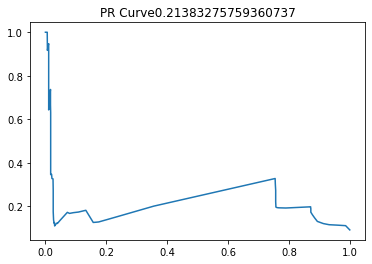

100%|██████████| 4/4 [00:00<00:00, 710.00it/s]


AUC : 0.2121 


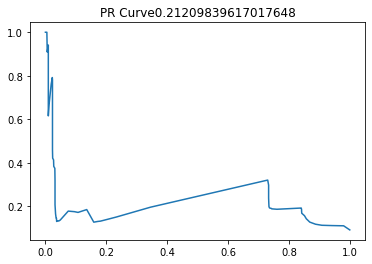

100%|██████████| 4/4 [00:00<00:00, 395.32it/s]


AUC : 0.2150 


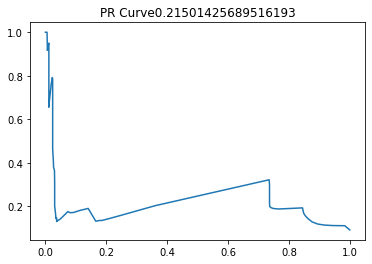

100%|██████████| 4/4 [00:00<00:00, 662.50it/s]


AUC : 0.2121 


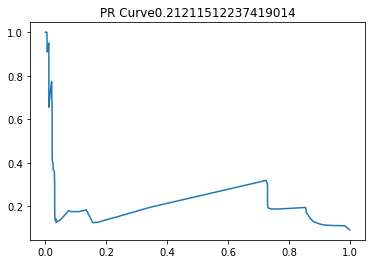

100%|██████████| 4/4 [00:00<00:00, 811.12it/s]


AUC : 0.2147 


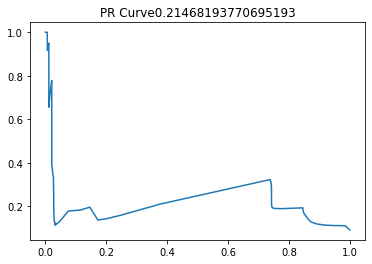

 Mean AUC  0.2135484941480176
 AUC std 0.001238652431156422


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy layerwise pretarining started
 Num AE layers  3
Adding layer : 1
Adding layer index  0
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 47.409355


 10%|█         | 1/10 [00:00<00:02,  3.02it/s]

 Epoch 1 loss 2.338648
Loss 0.816303


 20%|██        | 2/10 [00:00<00:02,  3.09it/s]

 Epoch 2 loss 0.641483
Loss 0.516022


 30%|███       | 3/10 [00:00<00:02,  3.11it/s]

 Epoch 3 loss 0.476520
Loss 0.414598


 40%|████      | 4/10 [00:01<00:01,  3.19it/s]

 Epoch 4 loss 0.421668
Loss 0.428570


 50%|█████     | 5/10 [00:01<00:01,  3.21it/s]

 Epoch 5 loss 0.367278
Loss 0.331142


 60%|██████    | 6/10 [00:01<00:01,  3.25it/s]

 Epoch 6 loss 0.326526
Loss 0.348656


 70%|███████   | 7/10 [00:02<00:00,  3.13it/s]

 Epoch 7 loss 0.313671
Loss 0.358912


 80%|████████  | 8/10 [00:02<00:00,  3.16it/s]

 Epoch 8 loss 0.303658
Loss 0.321779


 90%|█████████ | 9/10 [00:02<00:00,  3.22it/s]

 Epoch 9 loss 0.296223
Loss 0.310071


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 0.290487
Adding layer : 2
Adding layer index  1
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 36.268837


 10%|█         | 1/10 [00:00<00:04,  2.11it/s]

 Epoch 1 loss 4.150805
Loss 3.457427


 20%|██        | 2/10 [00:00<00:03,  2.21it/s]

 Epoch 2 loss 3.585415
Loss 3.537777


 30%|███       | 3/10 [00:01<00:03,  2.26it/s]

 Epoch 3 loss 3.582640
Loss 3.399343


 40%|████      | 4/10 [00:01<00:02,  2.40it/s]

 Epoch 4 loss 3.561105
Loss 3.500469


 50%|█████     | 5/10 [00:02<00:02,  2.48it/s]

 Epoch 5 loss 3.526080
Loss 3.844222


 60%|██████    | 6/10 [00:02<00:01,  2.48it/s]

 Epoch 6 loss 3.467474
Loss 3.461878


 70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

 Epoch 7 loss 3.483560
Loss 3.418976


 80%|████████  | 8/10 [00:03<00:00,  2.64it/s]

 Epoch 8 loss 3.513743
Loss 3.599268


 90%|█████████ | 9/10 [00:03<00:00,  2.68it/s]

 Epoch 9 loss 3.514209
Loss 3.516775


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.510332
Adding layer : 3
Adding layer index  2
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmo

 10%|█         | 1/10 [00:00<00:03,  2.37it/s]

 Epoch 1 loss 5.715559
Loss 3.602479


 20%|██        | 2/10 [00:00<00:03,  2.44it/s]

 Epoch 2 loss 3.503432
Loss 3.638431


 30%|███       | 3/10 [00:01<00:02,  2.48it/s]

 Epoch 3 loss 3.495661
Loss 3.442647


 40%|████      | 4/10 [00:01<00:02,  2.51it/s]

 Epoch 4 loss 3.477132
Loss 3.470945


 50%|█████     | 5/10 [00:01<00:01,  2.53it/s]

 Epoch 5 loss 3.469528
Loss 3.561675


 60%|██████    | 6/10 [00:02<00:01,  2.55it/s]

 Epoch 6 loss 3.461813
Loss 3.307418


 70%|███████   | 7/10 [00:02<00:01,  2.56it/s]

 Epoch 7 loss 3.462281
Loss 3.539229


 80%|████████  | 8/10 [00:03<00:00,  2.56it/s]

 Epoch 8 loss 3.439184
Loss 3.355384


 90%|█████████ | 9/10 [00:03<00:00,  2.59it/s]

 Epoch 9 loss 3.437157
Loss 3.542772


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.430209
Greedy layer-wise pretraining [Done]
Loss 3.437602


 10%|█         | 1/10 [00:00<00:05,  1.58it/s]

 Epoch 1 loss 3.526459
Loss 3.217509


 20%|██        | 2/10 [00:01<00:05,  1.59it/s]

 Epoch 2 loss 3.171663
Loss 3.109060


 30%|███       | 3/10 [00:01<00:04,  1.60it/s]

 Epoch 3 loss 3.110849
Loss 3.026858


 40%|████      | 4/10 [00:02<00:03,  1.60it/s]

 Epoch 4 loss 3.063729
Loss 2.813497


 50%|█████     | 5/10 [00:03<00:02,  1.70it/s]

 Epoch 5 loss 3.006566
Loss 3.103824


 60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

 Epoch 6 loss 2.951273
Loss 2.948372


 70%|███████   | 7/10 [00:04<00:01,  1.83it/s]

 Epoch 7 loss 2.898452
Loss 2.878127


 80%|████████  | 8/10 [00:04<00:01,  1.87it/s]

 Epoch 8 loss 2.880969
Loss 2.832807


 90%|█████████ | 9/10 [00:05<00:00,  1.90it/s]

 Epoch 9 loss 2.883741
Loss 2.871166


  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 10 loss 2.881384
Epoch :: 1
Loss 2.927475


  4%|▍         | 1/25 [00:00<00:12,  1.86it/s]

Epoch :: 2
Loss 2.845268


  8%|▊         | 2/25 [00:01<00:12,  1.90it/s]

Epoch :: 3
Loss 2.868212


 12%|█▏        | 3/25 [00:01<00:11,  1.93it/s]

Epoch :: 4
Loss 2.861257


 16%|█▌        | 4/25 [00:02<00:10,  1.92it/s]

Epoch :: 5
Loss 2.852778


 20%|██        | 5/25 [00:02<00:11,  1.80it/s]

Epoch :: 6
Loss 2.724624


 24%|██▍       | 6/25 [00:03<00:10,  1.85it/s]

Epoch :: 7
Loss 2.856680


 28%|██▊       | 7/25 [00:03<00:09,  1.88it/s]

Epoch :: 8
Loss 2.851762


 32%|███▏      | 8/25 [00:04<00:09,  1.78it/s]

Epoch :: 9
Loss 2.986262


 36%|███▌      | 9/25 [00:04<00:09,  1.72it/s]

Epoch :: 10
Loss 2.844659


 40%|████      | 10/25 [00:05<00:08,  1.80it/s]

Epoch :: 11
Loss 2.971215


 44%|████▍     | 11/25 [00:06<00:07,  1.82it/s]

Epoch :: 12
Loss 2.895637


 48%|████▊     | 12/25 [00:06<00:06,  1.88it/s]

Epoch :: 13
Loss 2.946656


 52%|█████▏    | 13/25 [00:07<00:06,  1.84it/s]

Epoch :: 14
Loss 2.917680


 56%|█████▌    | 14/25 [00:07<00:05,  1.85it/s]

Epoch :: 15
Loss 2.776194


 60%|██████    | 15/25 [00:08<00:05,  1.84it/s]

Epoch :: 16
Loss 2.849496


 64%|██████▍   | 16/25 [00:08<00:04,  1.83it/s]

Epoch :: 17
Loss 2.803612


 68%|██████▊   | 17/25 [00:09<00:04,  1.86it/s]

Epoch :: 18
Loss 2.844551


 72%|███████▏  | 18/25 [00:09<00:03,  1.91it/s]

Epoch :: 19
Loss 2.799389


 76%|███████▌  | 19/25 [00:10<00:03,  1.96it/s]

Epoch :: 20
Loss 2.847918


 80%|████████  | 20/25 [00:10<00:02,  1.98it/s]

Epoch :: 21
Loss 2.968983


 84%|████████▍ | 21/25 [00:11<00:01,  2.01it/s]

Epoch :: 22
Loss 2.861403


 88%|████████▊ | 22/25 [00:11<00:01,  1.97it/s]

Epoch :: 23
Loss 2.881429


 92%|█████████▏| 23/25 [00:12<00:01,  1.90it/s]

Epoch :: 24
Loss 2.862812


 96%|█████████▌| 24/25 [00:12<00:00,  1.92it/s]

Epoch :: 25
Loss 2.961971


100%|██████████| 4/4 [00:00<00:00, 520.97it/s]


AUC : 0.1514 


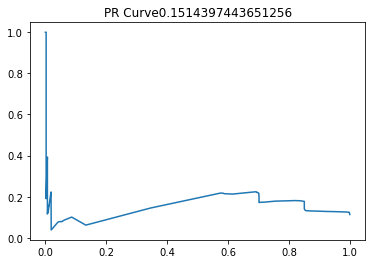

100%|██████████| 4/4 [00:00<00:00, 431.75it/s]


AUC : 0.1512 


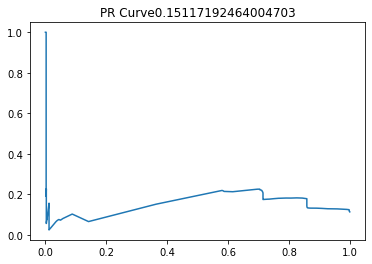

100%|██████████| 4/4 [00:00<00:00, 716.24it/s]


AUC : 0.1504 


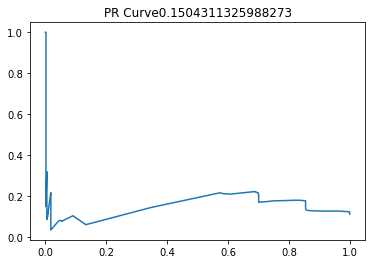

100%|██████████| 4/4 [00:00<00:00, 435.57it/s]


AUC : 0.1538 


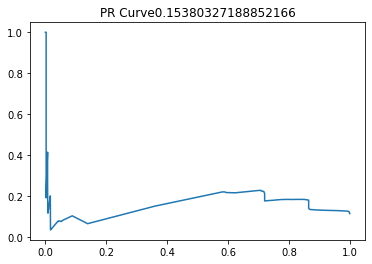

100%|██████████| 4/4 [00:00<00:00, 440.88it/s]


AUC : 0.1552 


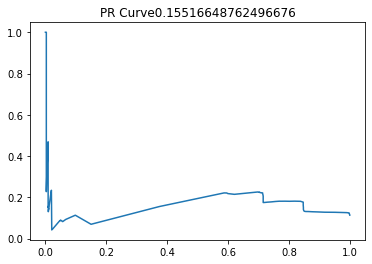

 Mean AUC  0.15240251222349768
 AUC std 0.0017848973658620892


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy layerwise pretarining started
 Num AE layers  3
Adding layer : 1
Adding layer index  0
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 47.536072


 10%|█         | 1/10 [00:00<00:02,  3.50it/s]

 Epoch 1 loss 2.482683
Loss 0.948247


 20%|██        | 2/10 [00:00<00:02,  3.56it/s]

 Epoch 2 loss 0.802184
Loss 0.678415


 30%|███       | 3/10 [00:00<00:01,  3.61it/s]

 Epoch 3 loss 0.634791
Loss 0.526556


 40%|████      | 4/10 [00:01<00:01,  3.67it/s]

 Epoch 4 loss 0.508111
Loss 0.484120


 50%|█████     | 5/10 [00:01<00:01,  3.61it/s]

 Epoch 5 loss 0.405097
Loss 0.320208


 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 Epoch 6 loss 0.360710
Loss 0.401123


 70%|███████   | 7/10 [00:02<00:00,  3.18it/s]

 Epoch 7 loss 0.349611
Loss 0.354464


 80%|████████  | 8/10 [00:02<00:00,  3.24it/s]

 Epoch 8 loss 0.340236
Loss 0.313019


 90%|█████████ | 9/10 [00:02<00:00,  3.27it/s]

 Epoch 9 loss 0.331638
Loss 0.287660


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 0.309969
Adding layer : 2
Adding layer index  1
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 52.496452


 10%|█         | 1/10 [00:00<00:03,  2.87it/s]

 Epoch 1 loss 4.297669
Loss 3.600751


 20%|██        | 2/10 [00:00<00:02,  2.93it/s]

 Epoch 2 loss 3.555047
Loss 3.515219


 30%|███       | 3/10 [00:01<00:02,  2.93it/s]

 Epoch 3 loss 3.495464
Loss 3.584485


 40%|████      | 4/10 [00:01<00:02,  2.94it/s]

 Epoch 4 loss 3.448341
Loss 3.480010


 50%|█████     | 5/10 [00:01<00:01,  2.85it/s]

 Epoch 5 loss 3.421760
Loss 3.315603


 60%|██████    | 6/10 [00:02<00:01,  2.79it/s]

 Epoch 6 loss 3.438924
Loss 3.373241


 70%|███████   | 7/10 [00:02<00:01,  2.84it/s]

 Epoch 7 loss 3.466413
Loss 3.431646


 80%|████████  | 8/10 [00:02<00:00,  2.87it/s]

 Epoch 8 loss 3.462020
Loss 3.484504


 90%|█████████ | 9/10 [00:03<00:00,  2.89it/s]

 Epoch 9 loss 3.434579
Loss 3.587310


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.435917
Adding layer : 3
Adding layer index  2
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmo

 10%|█         | 1/10 [00:00<00:03,  2.53it/s]

 Epoch 1 loss 4.223202
Loss 3.884455


 20%|██        | 2/10 [00:00<00:03,  2.55it/s]

 Epoch 2 loss 3.961685
Loss 3.908577


 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

 Epoch 3 loss 3.915472
Loss 3.890096


 40%|████      | 4/10 [00:01<00:02,  2.58it/s]

 Epoch 4 loss 3.626685
Loss 3.451581


 50%|█████     | 5/10 [00:01<00:01,  2.58it/s]

 Epoch 5 loss 3.410266
Loss 3.615134


 60%|██████    | 6/10 [00:02<00:01,  2.58it/s]

 Epoch 6 loss 3.400222
Loss 3.267158


 70%|███████   | 7/10 [00:02<00:01,  2.59it/s]

 Epoch 7 loss 3.404098
Loss 3.446643


 80%|████████  | 8/10 [00:03<00:00,  2.58it/s]

 Epoch 8 loss 3.401233
Loss 3.306454


 90%|█████████ | 9/10 [00:03<00:00,  2.56it/s]

 Epoch 9 loss 3.394570
Loss 3.498631


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.386617
Greedy layer-wise pretraining [Done]
Loss 3.279963


 10%|█         | 1/10 [00:00<00:04,  1.89it/s]

 Epoch 1 loss 3.730186
Loss 3.687072


 20%|██        | 2/10 [00:01<00:04,  1.91it/s]

 Epoch 2 loss 3.528831
Loss 3.346373


 30%|███       | 3/10 [00:01<00:03,  1.86it/s]

 Epoch 3 loss 3.423967
Loss 3.432746


 40%|████      | 4/10 [00:02<00:03,  1.89it/s]

 Epoch 4 loss 3.382376
Loss 3.487002


 50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

 Epoch 5 loss 3.372880
Loss 3.456434


 60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

 Epoch 6 loss 3.372412
Loss 3.434133


 70%|███████   | 7/10 [00:03<00:01,  1.86it/s]

 Epoch 7 loss 3.369412
Loss 3.325881


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

 Epoch 8 loss 3.346699
Loss 3.454033


 90%|█████████ | 9/10 [00:04<00:00,  1.75it/s]

 Epoch 9 loss 3.307679
Loss 3.133163


  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 10 loss 3.262648
Epoch :: 1
Loss 3.301824


  4%|▍         | 1/25 [00:00<00:12,  1.91it/s]

Epoch :: 2
Loss 2.955996


  8%|▊         | 2/25 [00:01<00:11,  1.95it/s]

Epoch :: 3
Loss 2.871224


 12%|█▏        | 3/25 [00:01<00:11,  1.98it/s]

Epoch :: 4
Loss 2.913472


 16%|█▌        | 4/25 [00:01<00:10,  2.00it/s]

Epoch :: 5
Loss 2.842894


 20%|██        | 5/25 [00:02<00:09,  2.02it/s]

Epoch :: 6
Loss 2.951171


 24%|██▍       | 6/25 [00:02<00:09,  2.03it/s]

Epoch :: 7
Loss 2.751702


 28%|██▊       | 7/25 [00:03<00:08,  2.04it/s]

Epoch :: 8
Loss 2.818519


 32%|███▏      | 8/25 [00:03<00:08,  2.04it/s]

Epoch :: 9
Loss 2.779449


 36%|███▌      | 9/25 [00:04<00:07,  2.05it/s]

Epoch :: 10
Loss 2.739610


 40%|████      | 10/25 [00:04<00:07,  2.05it/s]

Epoch :: 11
Loss 2.764464


 44%|████▍     | 11/25 [00:05<00:06,  2.05it/s]

Epoch :: 12
Loss 2.664910


 48%|████▊     | 12/25 [00:05<00:06,  2.05it/s]

Epoch :: 13
Loss 2.966618


 52%|█████▏    | 13/25 [00:06<00:05,  2.05it/s]

Epoch :: 14
Loss 2.859487


 56%|█████▌    | 14/25 [00:06<00:05,  1.97it/s]

Epoch :: 15
Loss 2.761840


 60%|██████    | 15/25 [00:07<00:05,  1.93it/s]

Epoch :: 16
Loss 2.610686


 64%|██████▍   | 16/25 [00:08<00:04,  1.83it/s]

Epoch :: 17
Loss 2.923909


 68%|██████▊   | 17/25 [00:08<00:04,  1.77it/s]

Epoch :: 18
Loss 2.750238


 72%|███████▏  | 18/25 [00:09<00:04,  1.74it/s]

Epoch :: 19
Loss 2.744648


 76%|███████▌  | 19/25 [00:09<00:03,  1.65it/s]

Epoch :: 20
Loss 2.823816


 80%|████████  | 20/25 [00:10<00:03,  1.66it/s]

Epoch :: 21
Loss 2.751594


 84%|████████▍ | 21/25 [00:11<00:02,  1.68it/s]

Epoch :: 22
Loss 2.872561


 88%|████████▊ | 22/25 [00:11<00:01,  1.75it/s]

Epoch :: 23
Loss 2.803515


 92%|█████████▏| 23/25 [00:12<00:01,  1.75it/s]

Epoch :: 24
Loss 2.753506


 96%|█████████▌| 24/25 [00:12<00:00,  1.79it/s]

Epoch :: 25
Loss 2.834440


100%|██████████| 4/4 [00:00<00:00, 509.51it/s]


AUC : 0.2429 


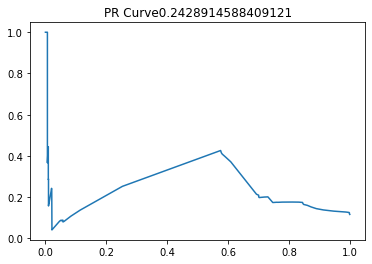

100%|██████████| 4/4 [00:00<00:00, 645.90it/s]


AUC : 0.2480 


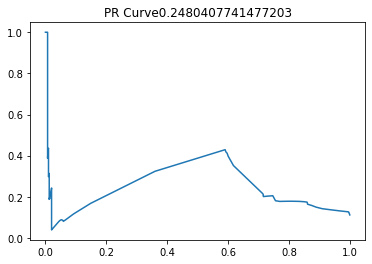

100%|██████████| 4/4 [00:00<00:00, 774.54it/s]


AUC : 0.2491 


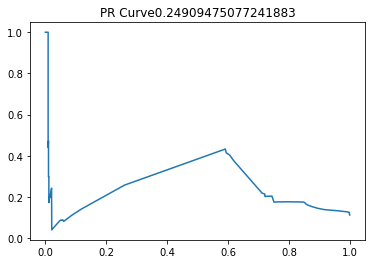

100%|██████████| 4/4 [00:00<00:00, 690.05it/s]


AUC : 0.2468 


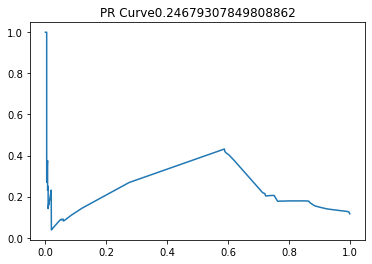

100%|██████████| 4/4 [00:00<00:00, 465.70it/s]


AUC : 0.2370 


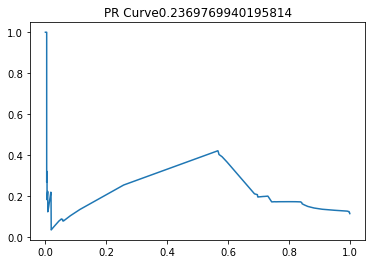

 Mean AUC  0.24475941125574424
 AUC std 0.0044216191122272


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy layerwise pretarining started
 Num AE layers  3
Adding layer : 1
Adding layer index  0
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 47.887402


 10%|█         | 1/10 [00:00<00:02,  3.16it/s]

 Epoch 1 loss 2.490566
Loss 0.808818


 20%|██        | 2/10 [00:00<00:02,  3.18it/s]

 Epoch 2 loss 0.561589
Loss 0.348891


 30%|███       | 3/10 [00:00<00:02,  3.21it/s]

 Epoch 3 loss 0.343111
Loss 0.325375


 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 Epoch 4 loss 0.290339
Loss 0.303649


 50%|█████     | 5/10 [00:01<00:01,  3.26it/s]

 Epoch 5 loss 0.262952
Loss 0.205710


 60%|██████    | 6/10 [00:01<00:01,  3.23it/s]

 Epoch 6 loss 0.239883
Loss 0.209741


 70%|███████   | 7/10 [00:02<00:00,  3.26it/s]

 Epoch 7 loss 0.208148
Loss 0.187882


 80%|████████  | 8/10 [00:02<00:00,  3.25it/s]

 Epoch 8 loss 0.199963
Loss 0.180749


 90%|█████████ | 9/10 [00:02<00:00,  3.28it/s]

 Epoch 9 loss 0.191466
Loss 0.148494


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 0.186955
Adding layer : 2
Adding layer index  1
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmoid()
    )
  )
)
Loss 20.940983


 10%|█         | 1/10 [00:00<00:03,  2.67it/s]

 Epoch 1 loss 2.822325
Loss 2.392729


 20%|██        | 2/10 [00:00<00:02,  2.71it/s]

 Epoch 2 loss 2.286661
Loss 2.085976


 30%|███       | 3/10 [00:01<00:02,  2.70it/s]

 Epoch 3 loss 2.222002
Loss 2.175052


 40%|████      | 4/10 [00:01<00:02,  2.68it/s]

 Epoch 4 loss 2.222157
Loss 2.169399


 50%|█████     | 5/10 [00:01<00:01,  2.70it/s]

 Epoch 5 loss 2.192030
Loss 2.062627


 60%|██████    | 6/10 [00:02<00:01,  2.70it/s]

 Epoch 6 loss 2.174688
Loss 2.093717


 70%|███████   | 7/10 [00:02<00:01,  2.73it/s]

 Epoch 7 loss 2.173555
Loss 2.148207


 80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

 Epoch 8 loss 2.151070
Loss 2.102302


 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

 Epoch 9 loss 2.158038
Loss 2.167552


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 2.148186
Adding layer : 3
Adding layer index  2
Current model  module_LPT_AE(
  (module_encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=194, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=8, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
  )
  (module_decoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=194, bias=True)
      (1): Sigmo

 10%|█         | 1/10 [00:00<00:04,  2.06it/s]

 Epoch 1 loss 3.673053
Loss 3.326287


 20%|██        | 2/10 [00:00<00:03,  2.07it/s]

 Epoch 2 loss 3.271258
Loss 3.280432


 30%|███       | 3/10 [00:01<00:03,  2.05it/s]

 Epoch 3 loss 3.225586
Loss 3.418153


 40%|████      | 4/10 [00:01<00:02,  2.15it/s]

 Epoch 4 loss 3.215341
Loss 3.104837


 50%|█████     | 5/10 [00:02<00:02,  2.29it/s]

 Epoch 5 loss 3.179809
Loss 3.221064


 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

 Epoch 6 loss 3.181912
Loss 2.962524


 70%|███████   | 7/10 [00:03<00:01,  2.17it/s]

 Epoch 7 loss 3.175077
Loss 3.199292


 80%|████████  | 8/10 [00:03<00:00,  2.20it/s]

 Epoch 8 loss 3.186138
Loss 3.190221


 90%|█████████ | 9/10 [00:04<00:00,  2.20it/s]

 Epoch 9 loss 3.194115
Loss 3.220831


  0%|          | 0/10 [00:00<?, ?it/s]

 Epoch 10 loss 3.222448
Greedy layer-wise pretraining [Done]
Loss 3.201945


 10%|█         | 1/10 [00:00<00:05,  1.78it/s]

 Epoch 1 loss 3.667250
Loss 3.432302


 20%|██        | 2/10 [00:01<00:04,  1.82it/s]

 Epoch 2 loss 2.258714
Loss 1.798634


 30%|███       | 3/10 [00:01<00:03,  1.83it/s]

 Epoch 3 loss 1.741604
Loss 1.780053


 40%|████      | 4/10 [00:02<00:03,  1.82it/s]

 Epoch 4 loss 1.620995
Loss 1.565315


 50%|█████     | 5/10 [00:02<00:02,  1.76it/s]

 Epoch 5 loss 1.589241
Loss 1.619860


 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

 Epoch 6 loss 1.568680
Loss 1.503363


 70%|███████   | 7/10 [00:03<00:01,  1.74it/s]

 Epoch 7 loss 1.552613
Loss 1.651776


 80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

 Epoch 8 loss 1.549165
Loss 1.540824


 90%|█████████ | 9/10 [00:05<00:00,  1.71it/s]

 Epoch 9 loss 1.548437
Loss 1.480332


  0%|          | 0/25 [00:00<?, ?it/s]

 Epoch 10 loss 1.557525
Epoch :: 1
Loss 1.503718


  4%|▍         | 1/25 [00:00<00:15,  1.52it/s]

Epoch :: 2
Loss 1.542199


  8%|▊         | 2/25 [00:01<00:14,  1.56it/s]

Epoch :: 3
Loss 1.337577


 12%|█▏        | 3/25 [00:01<00:13,  1.60it/s]

Epoch :: 4
Loss 1.387734


 16%|█▌        | 4/25 [00:02<00:12,  1.68it/s]

Epoch :: 5
Loss 1.277274


 20%|██        | 5/25 [00:02<00:11,  1.73it/s]

Epoch :: 6
Loss 1.168699


 24%|██▍       | 6/25 [00:03<00:10,  1.81it/s]

Epoch :: 7
Loss 1.066858


 28%|██▊       | 7/25 [00:03<00:09,  1.84it/s]

Epoch :: 8
Loss 1.135085


 32%|███▏      | 8/25 [00:04<00:08,  1.89it/s]

Epoch :: 9
Loss 1.060735


 36%|███▌      | 9/25 [00:04<00:08,  1.89it/s]

Epoch :: 10
Loss 1.000055


 40%|████      | 10/25 [00:05<00:08,  1.87it/s]

Epoch :: 11
Loss 1.044534


 44%|████▍     | 11/25 [00:06<00:07,  1.80it/s]

Epoch :: 12
Loss 0.949174


 48%|████▊     | 12/25 [00:06<00:07,  1.77it/s]

Epoch :: 13
Loss 0.930028


 52%|█████▏    | 13/25 [00:07<00:06,  1.78it/s]

Epoch :: 14
Loss 0.977933


 56%|█████▌    | 14/25 [00:07<00:06,  1.83it/s]

Epoch :: 15
Loss 0.940839


 60%|██████    | 15/25 [00:08<00:05,  1.87it/s]

Epoch :: 16
Loss 0.939338


 64%|██████▍   | 16/25 [00:08<00:04,  1.90it/s]

Epoch :: 17
Loss 0.892568


 68%|██████▊   | 17/25 [00:09<00:04,  1.93it/s]

Epoch :: 18
Loss 0.873637


 72%|███████▏  | 18/25 [00:09<00:03,  1.93it/s]

Epoch :: 19
Loss 0.878748


 76%|███████▌  | 19/25 [00:10<00:03,  1.87it/s]

Epoch :: 20
Loss 0.878624


 80%|████████  | 20/25 [00:10<00:02,  1.87it/s]

Epoch :: 21
Loss 0.993826


 84%|████████▍ | 21/25 [00:11<00:02,  1.83it/s]

Epoch :: 22
Loss 0.884698


 88%|████████▊ | 22/25 [00:11<00:01,  1.87it/s]

Epoch :: 23
Loss 0.898403


 92%|█████████▏| 23/25 [00:12<00:01,  1.89it/s]

Epoch :: 24
Loss 0.898060


 96%|█████████▌| 24/25 [00:13<00:00,  1.80it/s]

Epoch :: 25
Loss 0.968821


100%|██████████| 4/4 [00:00<00:00, 732.18it/s]


AUC : 0.3358 


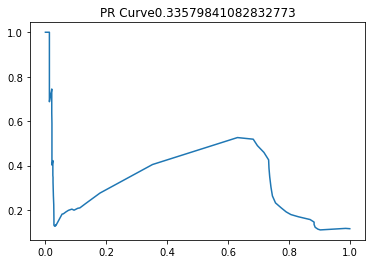

100%|██████████| 4/4 [00:00<00:00, 458.54it/s]


AUC : 0.3304 


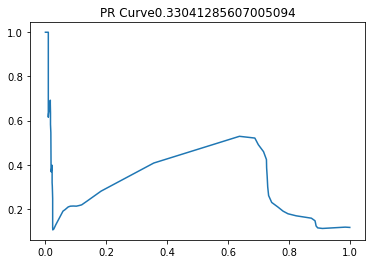

100%|██████████| 4/4 [00:00<00:00, 418.43it/s]


AUC : 0.3314 


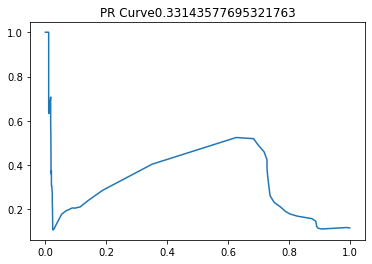

100%|██████████| 4/4 [00:00<00:00, 747.68it/s]


AUC : 0.3355 


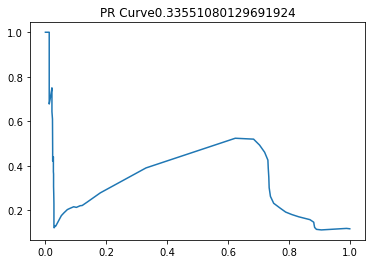

100%|██████████| 4/4 [00:00<00:00, 627.12it/s]


AUC : 0.3336 


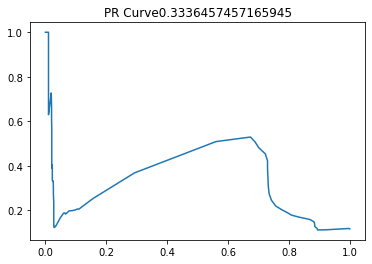

 Mean AUC  0.333360718173022
 AUC std 0.002146706002219636
Mean AuPR over  5 runs 0.238867
Details:  [0.2502631873209813, 0.2135484941480176, 0.15240251222349768, 0.24475941125574424, 0.333360718173022]


In [22]:
for n in range(1,num_runs+1):
    data_dict, _ = data_fetcher.get_data(
        DATA_SET,
        one_hot=True,
        num_anom_sets=num_anomaly_sets,
        anomaly_ratio=anomaly_ratio
    )

    dae_obj = train_model(DATA_SET, data_dict, config)
    mean_aupr, std = test_eval(dae_obj, data_dict, num_anomaly_sets)

    results.append(mean_aupr)
#     LOGGER.info(' Run {}: Mean: {:4f} | Std {:4f}'.format(n,mean_aupr,std))

mean_all_runs = np.mean(results)
print('Mean AuPR over  {} runs {:4f}'.format(num_runs, mean_all_runs))
print('Details: ', results)

# LOGGER.info('Mean AuPR over  {} runs {:4f} Std {:4f}'.format(num_runs, mean_all_runs, np.std(results)))
# LOGGER.info(' Details ' + str(results))
# utils.close_logger(LOGGER)

100%|██████████| 4/4 [00:00<00:00, 443.49it/s]


AUC : 0.2275 


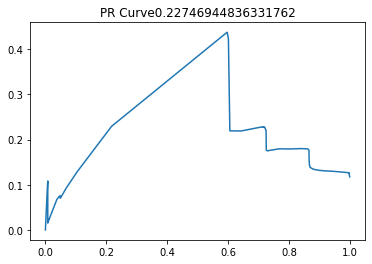

100%|██████████| 4/4 [00:00<00:00, 497.22it/s]


AUC : 0.2152 


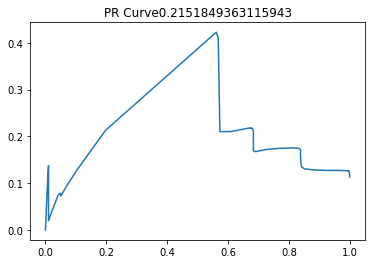

100%|██████████| 4/4 [00:00<00:00, 312.05it/s]


AUC : 0.2197 


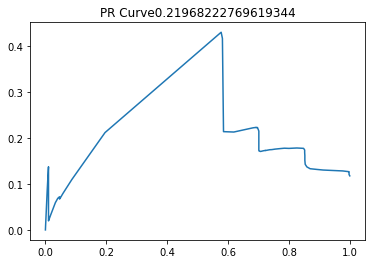

100%|██████████| 4/4 [00:00<00:00, 403.68it/s]


AUC : 0.2226 


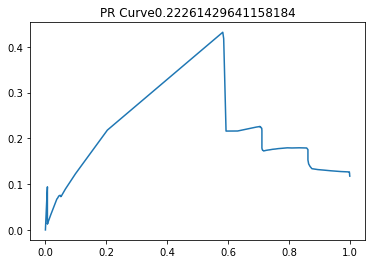

100%|██████████| 4/4 [00:00<00:00, 416.56it/s]


AUC : 0.2235 


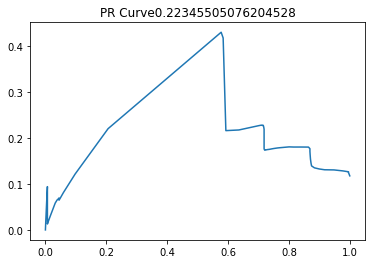

 Mean AUC  0.22168119190894647
 AUC std 0.004091903389258387


In [32]:
mean_aupr, std = test_eval(dae_obj, data_dict, num_anomaly_sets)

In [33]:
a = [0.8371563434981937, 0.7510143612083994, 0.8859430197580245, 0.8955063090396642,0.7425198323135804, 0.8081157507623169, 0.7509179352404016, 0.7655263413740194]
b =[0.7489371567598885, 0.9925652553367185, 0.9877722493098741, 0.9887765285918816, 0.7425198323135804, 0.8081157507623169, 0.7509179352404016, 0.7655263413740194]

Current device  >>  cuda


In [35]:
np.mean(b)

0.8481413812110852

In [36]:
c =[0.2523037769086851, 0.2106099990097045, 0.30487704481494177, 0.2541401498072732 ,0.22145673567374874, 0.23459187384183228, 0.2202658524914182, 0.21409737732807477]
np.mean(c)

0.2390428512344598

In [37]:
a1 = [0.785355,0.678398,0.7489371567598885, 0.9925652553367185, 
      0.9877722493098741, 0.9887765285918816,0.7425198323135804, 0.8081157507623169, 0.7509179352404016, 0.7655263413740194,0.7475464216325145, 0.7398091301994827]
np.mean(a1)

Current device  >>  cuda


0.8113533001267234